In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

In [91]:
df = pd.read_csv("./data.csv")

In [92]:
df = df.rename(columns={"tension_strenght": "tensile_strength"})

In [93]:
df

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [95]:
df.infill_pattern.value_counts()

infill_pattern
grid         25
honeycomb    25
Name: count, dtype: int64

In [96]:
df.material.value_counts()

material
abs    25
pla    25
Name: count, dtype: int64

In [97]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [98]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [99]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [100]:
target_cols = ['tensile_strength', 'roughness', 'elongation']
y = df[target_cols].values
x = df.drop(target_cols,axis=1).values

<Axes: xlabel='fan_speed', ylabel='tensile_strength'>

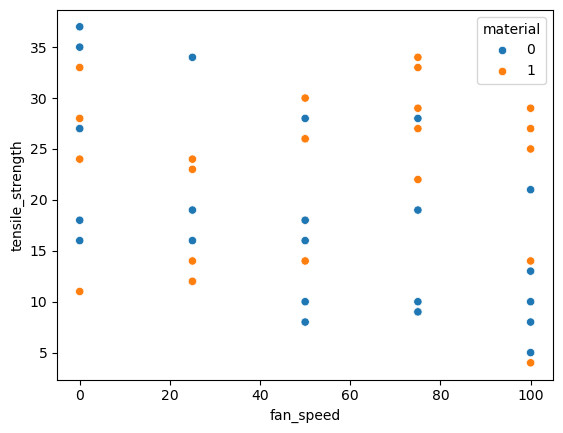

In [101]:
sns.scatterplot(x=df.fan_speed,y=df.tensile_strength,hue=df.material)

<Axes: xlabel='layer_height', ylabel='roughness'>

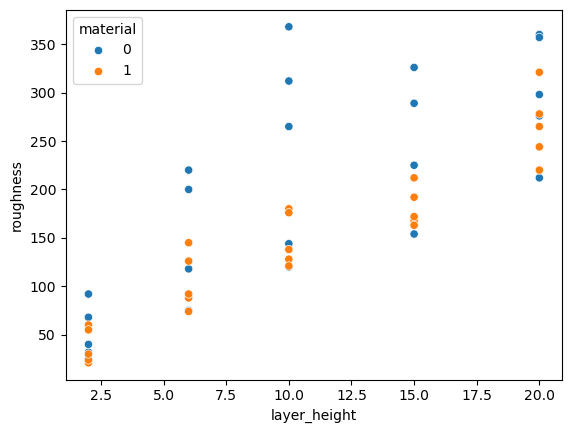

In [102]:
sns.scatterplot(x=df.layer_height,y=df.roughness,hue=df.material)

<Axes: xlabel='infill_pattern', ylabel='elongation'>

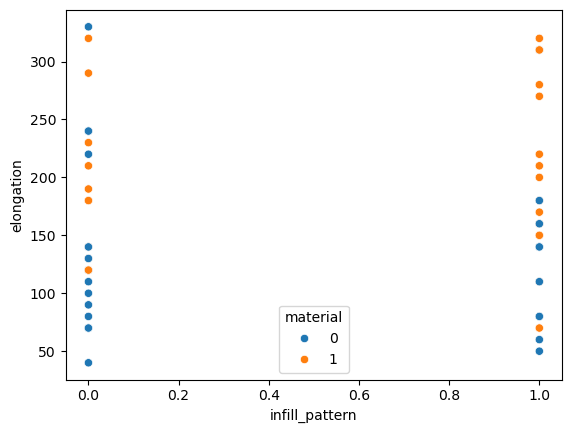

In [103]:
sns.scatterplot(x=df.infill_pattern,y=df.elongation,hue=df.material)

<Axes: xlabel='nozzle_temperature', ylabel='roughness'>

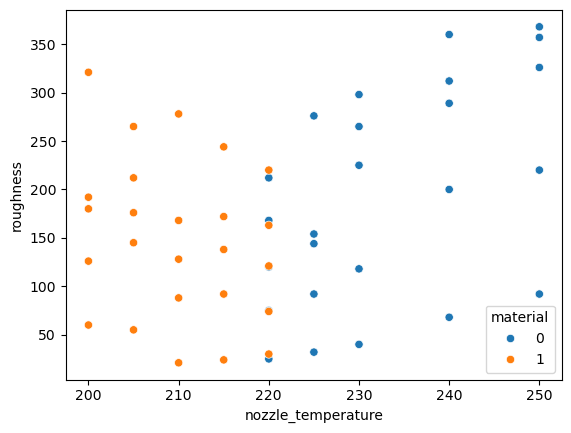

In [104]:
sns.scatterplot(x=df.nozzle_temperature,y=df.roughness,hue=df.material)

<Axes: xlabel='print_speed', ylabel='roughness'>

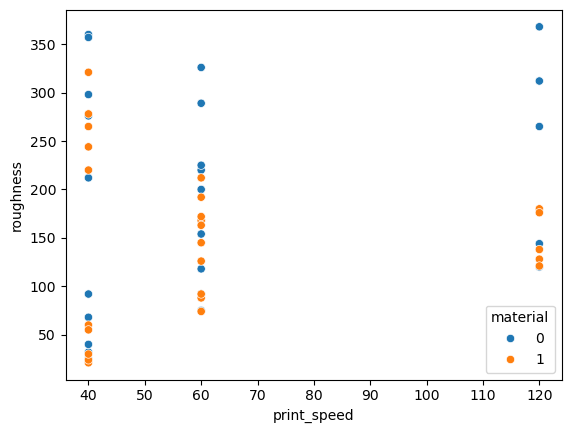

In [105]:
sns.scatterplot(x=df.print_speed,y=df.roughness,hue=df.material)

In [106]:
# import tensorflow as tf

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(9,)),  # Corrected
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.38),    
#     tf.keras.layers.PReLU(),   
#     tf.keras.layers.Dense(256),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.35),
#     tf.keras.layers.PReLU(),    
#     tf.keras.layers.Dense(3, activation="sigmoid")
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#               loss='mean_squared_error', 
#               metrics=['accuracy'])


In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim=9, output_dim=1):
        super(MLP, self).__init__()
        self.batchnorm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(input_dim, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.38)
        self.prelu1 = nn.PReLU()
        self.fc2 = nn.Linear(1024, 256)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.35)
        self.prelu2 = nn.PReLU()
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.prelu1(x)
        x = self.fc2(x)
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        x = self.prelu2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Activation for multi-label classification
        return x

# Initialize Model
model = MLP()

# Define Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Mean Squared Error (same as TensorFlow)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

In [108]:
output = model(x)

In [117]:
def strength_loss (output,y):
    y_target = y[:, 0].view(-1, 1)  
    str_loss = nn.MSELoss()(output, y_target)
    return str_loss

In [118]:
def rough_loss (output,y):
    y_target = y[:, 1].view(-1, 1)  
    rough_loss = nn.MSELoss()(output, y_target)
    return rough_loss

In [119]:
def elongation_loss (output,y):
    y_target = y[:, 2].view(-1, 1)  
    elongation_loss = nn.MSELoss()(output, y_target)
    return elongation_loss

In [ ]:


# # Loss function
# criterion = nn.MSELoss()  # Mean Squared Error (MSE)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # K-Fold Cross Validation
# kf = KFold(n_splits=5, shuffle=True)
# fold_train_losses, fold_val_losses = [], []
# fold_train_accuracies, fold_val_accuracies = [], []

# for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
#     print(f'Fold {fold + 1}')

#     # Split dataset
#     x_train, x_val = x[train_idx], x[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # Convert to DataLoader
#     train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=8, shuffle=True)
#     val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=8, shuffle=False)

#     # Initialize model and optimizer
#     model = MLP().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     train_losses, val_losses = [], []
#     train_accuracies, val_accuracies = [], []

#     # Training loop
#     for epoch in range(45):
#         model.train()
#         running_loss, correct, total = 0.0, 0, 0
#         for x_batch, y_batch in train_loader:
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device)

#             optimizer.zero_grad()
#             y_pred = model(x_batch)

#             loss = criterion(y_pred, y_batch)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             correct += (y_pred.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
#             total += y_batch.size(0)

#         train_loss = running_loss / len(train_loader)
#         train_accuracy = correct / total
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         # Validation
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         with torch.no_grad():
#             for x_batch, y_batch in val_loader:
#                 x_batch, y_batch = x_batch.to(device), y_batch.to(device)

#                 y_pred = model(x_batch)
#                 val_loss += criterion(y_pred, y_batch).item()
#                 val_correct += (y_pred.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
#                 val_total += y_batch.size(0)

#         val_loss /= len(val_loader)
#         val_accuracy = val_correct / val_total
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#         print(f"Epoch {epoch+1}/45 - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#     fold_train_losses.append(train_losses)
#     fold_val_losses.append(val_losses)
#     fold_train_accuracies.append(train_accuracies)
#     fold_val_accuracies.append(val_accuracies)

#     print("")



Fold 1
Epoch 1/45 - Train Loss: 24100.4859, Train Acc: 0.4750, Val Loss: 37436.4072, Val Acc: 0.4000
Epoch 2/45 - Train Loss: 24073.0836, Train Acc: 0.6500, Val Loss: 37431.7324, Val Acc: 0.4000
Epoch 3/45 - Train Loss: 24060.1035, Train Acc: 0.6500, Val Loss: 37404.4648, Val Acc: 0.4000
Epoch 4/45 - Train Loss: 24050.9820, Train Acc: 0.7500, Val Loss: 37363.0195, Val Acc: 0.4000
Epoch 5/45 - Train Loss: 24041.4688, Train Acc: 0.6000, Val Loss: 37335.0430, Val Acc: 0.5000
Epoch 6/45 - Train Loss: 24036.6527, Train Acc: 0.6250, Val Loss: 37322.0312, Val Acc: 0.5000
Epoch 7/45 - Train Loss: 24031.0727, Train Acc: 0.6750, Val Loss: 37315.7773, Val Acc: 0.6000
Epoch 8/45 - Train Loss: 24026.2066, Train Acc: 0.7250, Val Loss: 37308.6582, Val Acc: 0.5000
Epoch 9/45 - Train Loss: 24019.1242, Train Acc: 0.6500, Val Loss: 37303.1260, Val Acc: 0.5000
Epoch 10/45 - Train Loss: 24014.6969, Train Acc: 0.6250, Val Loss: 37299.7441, Val Acc: 0.6000
Epoch 11/45 - Train Loss: 24012.3695, Train Acc: 0.5

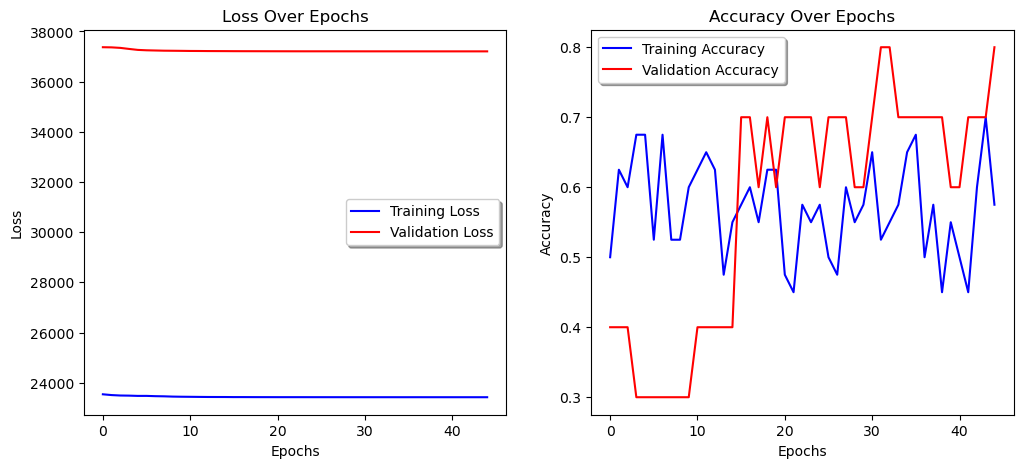

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.plot(train_losses, color='b', label='Training Loss')
# ax1.plot(val_losses, color='r', label='Validation Loss')
# ax1.set_title('Loss Over Epochs')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')
# ax1.legend(loc='best', shadow=True)

# ax2.plot(train_accuracies, color='b', label='Training Accuracy')
# ax2.plot(val_accuracies, color='r', label='Validation Accuracy')
# ax2.set_title('Accuracy Over Epochs')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Accuracy')
# ax2.legend(loc='best', shadow=True)

# plt.show()

In [122]:
from tqdm import trange

# Loss function
criterion = nn.MSELoss()  # Mean Squared Error (MSE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ADAM

epochs = 3000
best_loss = np.inf
pbar = trange(epochs)
model.train()

for epoch in pbar:
    loss_record_epoch = []
    optimizer.zero_grad()
    #residual loss
    
    output = model(x)
    loss =  strength_loss(output, y) + elongation_loss(output, y) + rough_loss(output, y)
  
    loss.backward()
    optimizer.step()
    #log batch loss
    loss_record_epoch.append(loss.item())

    try:
        sum_loss = sum(loss_record_epoch)
        avg_loss_epoch = sum_loss/len(loss_record_epoch)
    except ZeroDivisionError as e:
        print("error: ", e, "batch size larger than number of training examples")

    if epoch % 10 == 0 or epoch + 1 == epochs: 
        if avg_loss_epoch < best_loss:
            best_loss = avg_loss_epoch
           
        pbar.set_postfix(
        {
            'Train-Loss': avg_loss_epoch,
            'Best-Loss': best_loss,

        }
    )
    
    

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\yaoya\anaconda3\envs\NSGA_replica\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 3000/3000 [00:07<00:00, 411.06it/s, Train-Loss=7.25e+4, Best-Loss=7.25e+4]


In [124]:
print(criterion(output, y[:,0].view(-1, 1)  ))

tensor(442.1205, device='cuda:0', grad_fn=<MseLossBackward0>)


c:\Users\yaoya\anaconda3\envs\NSGA_replica\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
